In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import joblib

import lightgbm as lgb
from scipy.special import kl_div
from kl_divergence import score as kl_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

from engine_hms_trainer import *
from engine_hms_model import *

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
paths = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", paths.OUTPUT_DIR)

paths.MAE_PRETRAIN_MODEL = "./outputs/vit_mae_pretraining/ViTMAE_PreTrained_Best.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Output Dir:  ./outputs/
Device: cuda


In [3]:
train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(
    paths.TRAIN_CSV, paths.PRE_LOADED_SPECTOGRAMS, paths.PRE_LOADED_EEGS, split_entropy=ModelConfig.SPLIT_ENTROPY)

print(train_easy.shape)
print(train_hard.shape)

# check if contain NaN
print(train_easy.isnull().sum().sum())
print(train_hard.isnull().sum().sum())

display(train_easy.head())
print(" ")
display(train_hard.head())

(13996, 12)
(6187, 12)
0
0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,642382,0.0,0.0,0.0,0.0,0.0,1.0,14960202,1008.0,1032.0,5955,Other
1,751790,0.0,0.0,1.0,0.0,0.0,0.0,618728447,908.0,908.0,38549,GPD
2,778705,0.0,0.0,0.0,0.0,0.0,1.0,52296320,0.0,0.0,40955,Other
3,1629671,1.0,0.0,0.0,0.0,0.0,0.0,2036345030,0.0,160.0,37481,Seizure
4,2061593,0.0,0.0,0.0,0.0,0.0,1.0,320962633,1450.0,1450.0,23828,Other


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


torch.Size([16, 3, 224, 224])


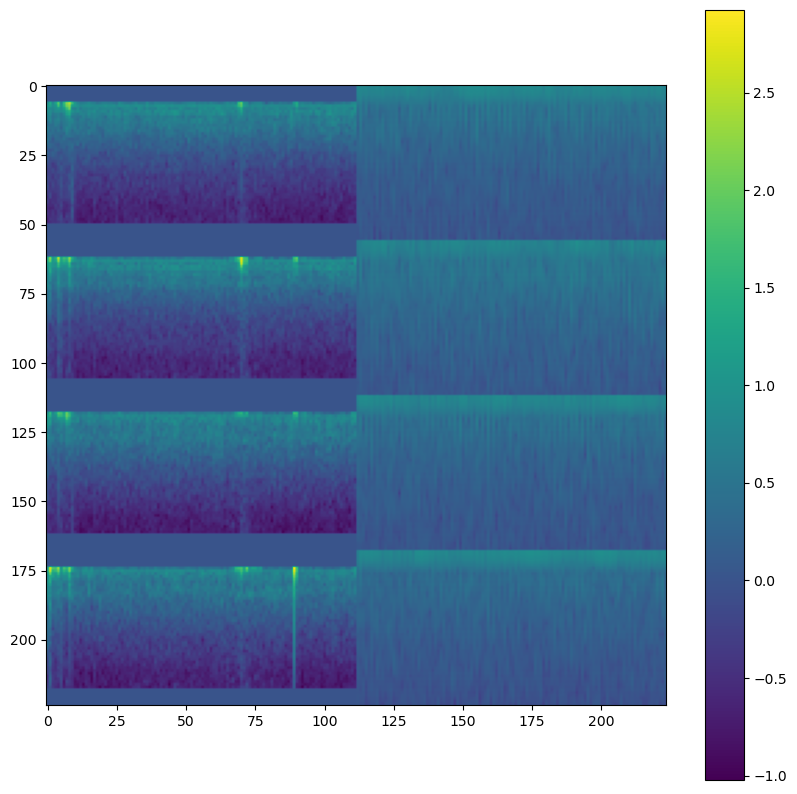

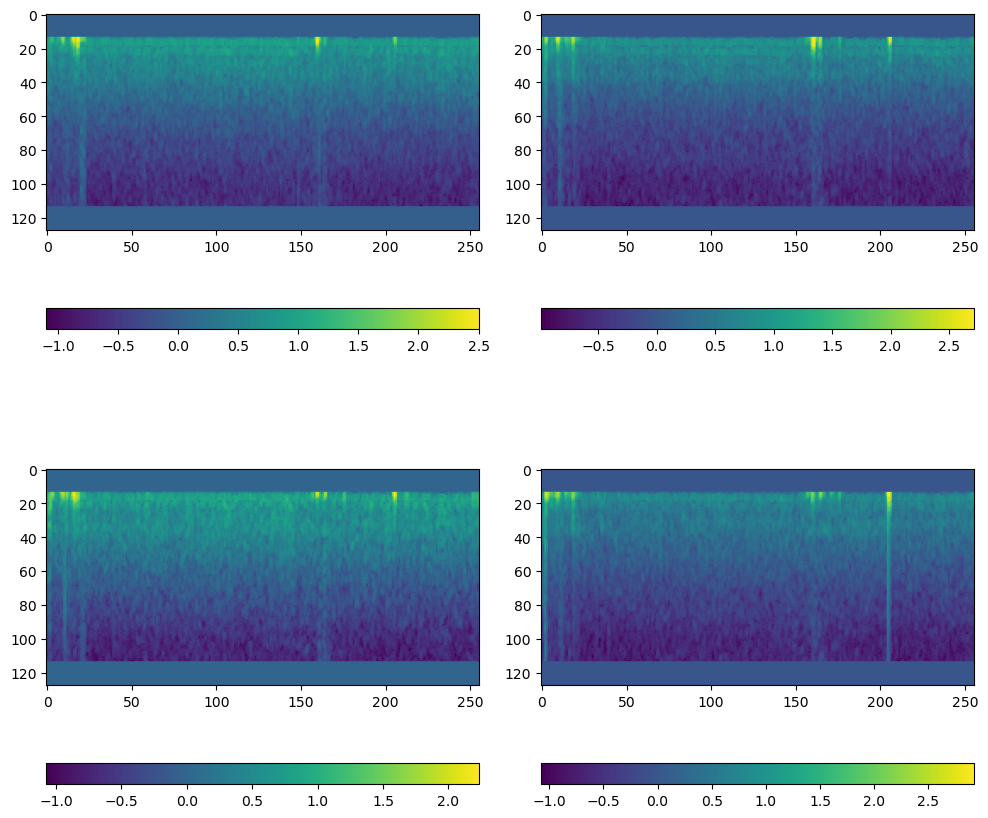

In [4]:
# visually check if the data is loaded correctly
ds_easy = PreTrainDataset(train_easy, all_specs, all_eegs)
easy_loader = DataLoader(ds_easy, batch_size=16, shuffle=False, collate_fn=reshape_pretrain_input)

for x in easy_loader:
    print(x.shape)
    break

im_id = 13

row = train_easy.iloc[im_id]
r = int((row['min'] + row['max']) // 4)

img_list = []
for i in range(4):
    img = np.zeros((128, 256), dtype=np.float32)
    spectrogram = all_specs[row['spectrogram_id']][r:r+300, i*100:(i+1)*100].T 
    spectrogram = transform_spectrogram(spectrogram)
    img[14:-14, :] = spectrogram[:, 22:-22] / 2.0
    img_list.append(img)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(x[im_id, 0], cmap='viridis')
fig.colorbar(im, ax=ax, orientation='vertical')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(img_list[i], cmap='viridis')
    fig.colorbar(im, ax=ax, orientation='horizontal')
fig.tight_layout()
plt.show()

In [5]:
def prepare_folds(df, n_folds=5):
    kf_split = KFold(n_splits=n_folds)
    unique_spec_id = df['spectrogram_id'].unique()

    for fold, (train_index, valid_index) in enumerate(kf_split.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df

def get_train_valid_folds(df, fold, easy_or_hard='easy'):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)

    train_df['is_train'] = True
    valid_df['easy_or_hard'] = easy_or_hard

    return train_df, valid_df

def train_lgbm(train_features, train_targets, valid_features, valid_targets, lgb_params, easy_or_hard, load_init_model=None):

    ft_train, ft_test, tgt_train, tgt_test = train_test_split(train_features, train_targets, test_size=0.2, random_state=42)

    lb_train = np.argmax(tgt_train, axis=1)
    lb_test = np.argmax(tgt_test, axis=1)
    
    gbm_model = lgb.LGBMClassifier(**lgb_params)

    if load_init_model is not None:
        if isinstance(load_init_model, str):
            init_model = joblib.load(load_init_model)
            init_model = init_model.booster_
        elif isinstance(load_init_model, lgb.Booster):
            init_model = load_init_model
        else:
            raise ValueError("Invalid init model type")
    else:
        init_model = None
    
    gbm_model.fit(
        ft_train, 
        lb_train,
        eval_set=[(ft_test, lb_test)],
        init_model=init_model,
        callbacks=[
            lgb.early_stopping(10, first_metric_only=True, verbose=True)
            ]
        )

    predict_targets = gbm_model.predict_proba(valid_features)
    kl_loss = kl_div(valid_targets, predict_targets).sum(axis=1).mean()

    return gbm_model, predict_targets, kl_loss

def plot_model_cm(model, train_features, valid_targets):

    valid_labels = valid_targets.argmax(axis=1)
    predict_labels = model.predict(train_features) 

    # plot the confusion matrix
    cm = confusion_matrix(valid_labels, predict_labels)
    cm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', cbar=False, fmt=".2f")
    ax.set_xticklabels([x.split('_')[0] for x in TARGETS], rotation=0)
    ax.set_yticklabels([x.split('_')[0] for x in TARGETS], rotation=90)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    fig.tight_layout()
    plt.show()

  0%|          | 0/442 [00:00<?, ?it/s]

--------------------------------------------------
Fold 0: Training Easy Model


  0%|          | 0/567 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[600]	valid_0's multi_logloss: 0.844874
Evaluated only: multi_logloss
Fold 0: KL Loss Easy: 0.8938


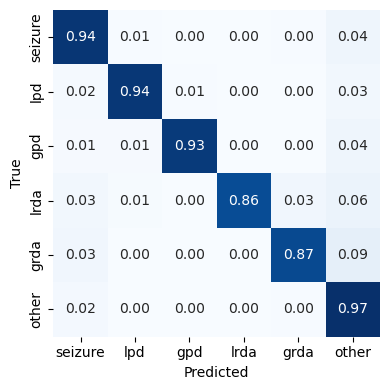

--------------------------------------------------
Fold 0: Training Hard Model


  0%|          | 0/266 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[940]	valid_0's multi_logloss: 1.12549
Evaluated only: multi_logloss
Fold 0: KL Loss Hard: 0.8199


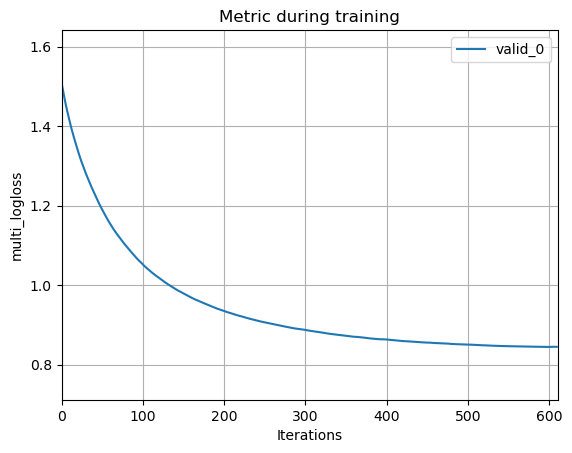

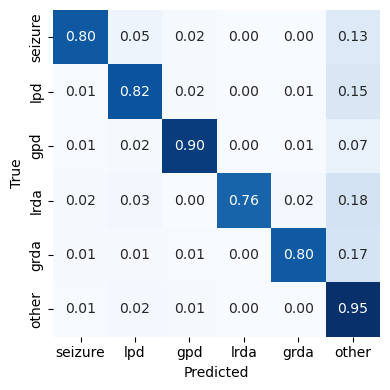

--------------------------------------------------


  0%|          | 0/263 [00:00<?, ?it/s]

--------------------------------------------------
Fold 1: Training Easy Model


  0%|          | 0/689 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[662]	valid_0's multi_logloss: 0.870591
Evaluated only: multi_logloss
Fold 1: KL Loss Easy: 0.8289


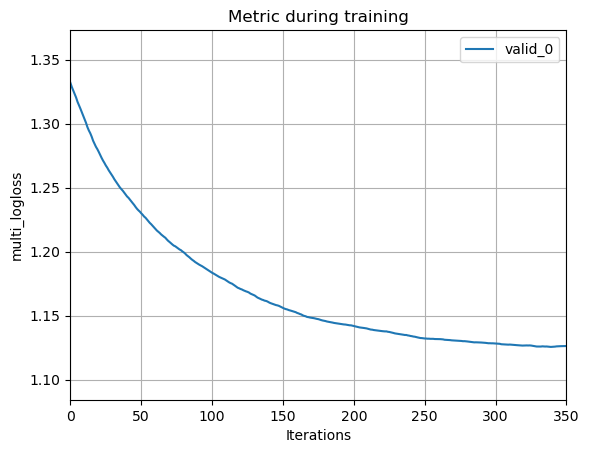

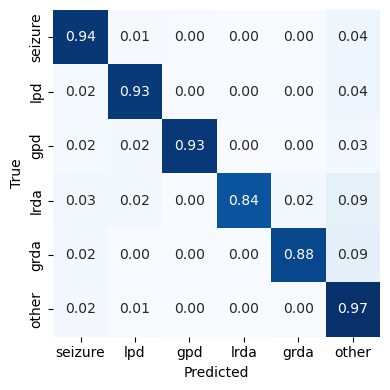

--------------------------------------------------
Fold 1: Training Hard Model


  0%|          | 0/311 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1141]	valid_0's multi_logloss: 1.06445
Evaluated only: multi_logloss
Fold 1: KL Loss Hard: 0.8274


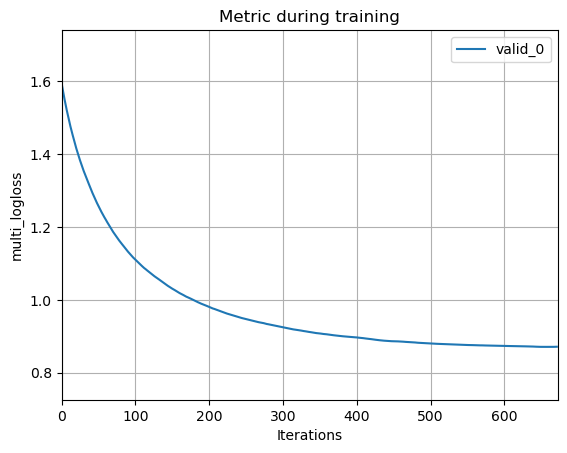

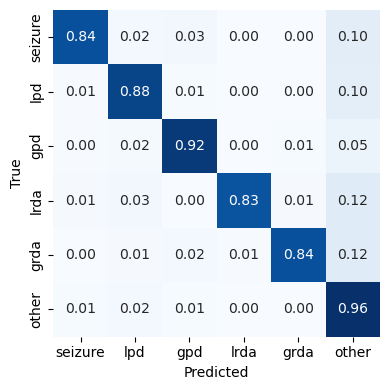

--------------------------------------------------


  0%|          | 0/209 [00:00<?, ?it/s]

--------------------------------------------------
Fold 2: Training Easy Model


  0%|          | 0/734 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[549]	valid_0's multi_logloss: 0.869567
Evaluated only: multi_logloss
Fold 2: KL Loss Easy: 0.8222


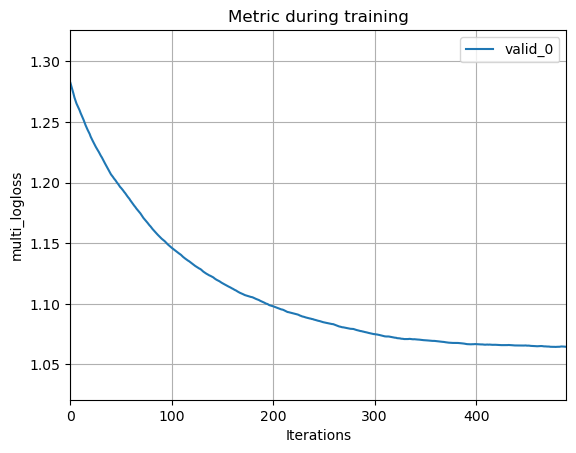

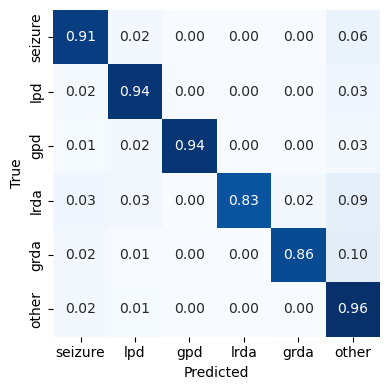

--------------------------------------------------
Fold 2: Training Hard Model


  0%|          | 0/318 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[999]	valid_0's multi_logloss: 1.09775
Evaluated only: multi_logloss
Fold 2: KL Loss Hard: 0.8569


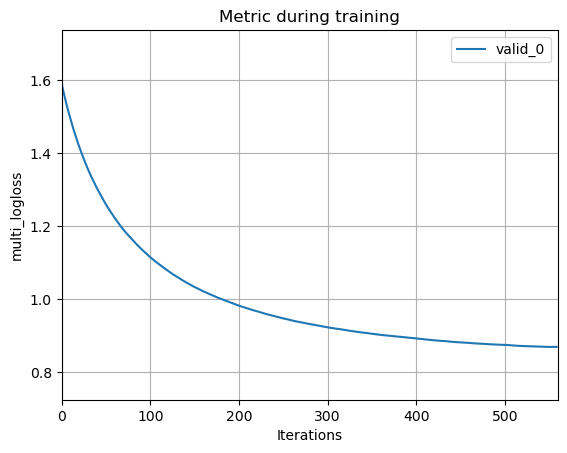

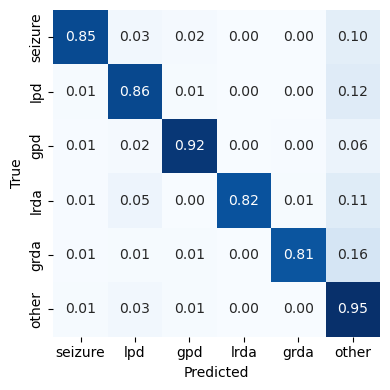

--------------------------------------------------


  0%|          | 0/184 [00:00<?, ?it/s]

--------------------------------------------------
Fold 3: Training Easy Model


  0%|          | 0/750 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[650]	valid_0's multi_logloss: 0.873771
Evaluated only: multi_logloss
Fold 3: KL Loss Easy: 0.8435


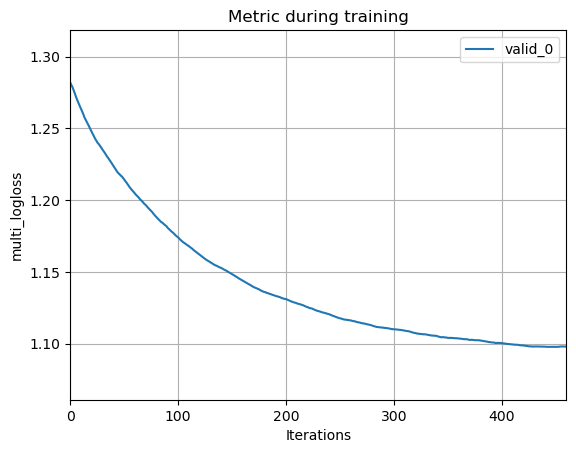

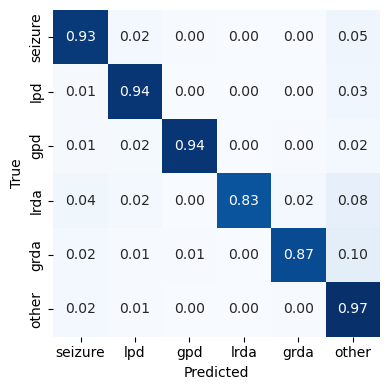

--------------------------------------------------
Fold 3: Training Hard Model


  0%|          | 0/325 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1070]	valid_0's multi_logloss: 1.09035
Evaluated only: multi_logloss
Fold 3: KL Loss Hard: 0.8848


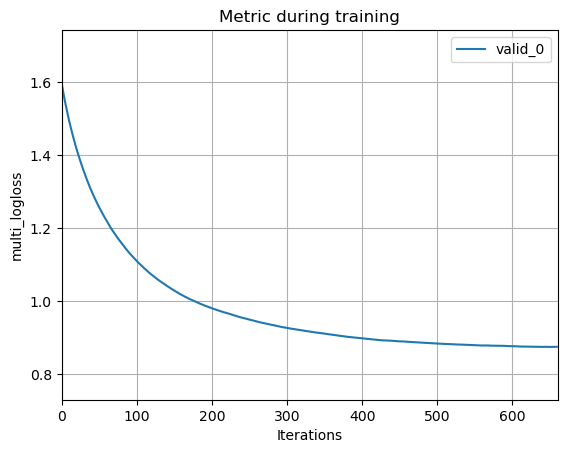

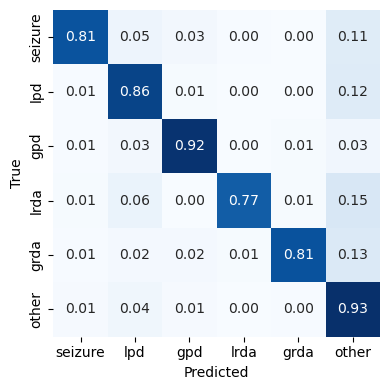

--------------------------------------------------


  0%|          | 0/172 [00:00<?, ?it/s]

--------------------------------------------------
Fold 4: Training Easy Model


  0%|          | 0/762 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[667]	valid_0's multi_logloss: 0.836643
Evaluated only: multi_logloss
Fold 4: KL Loss Easy: 0.8981


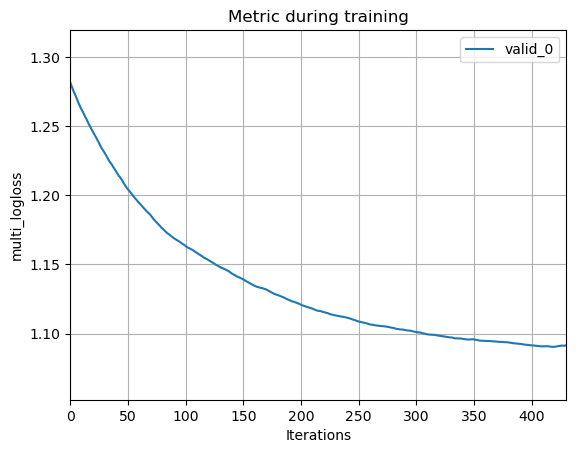

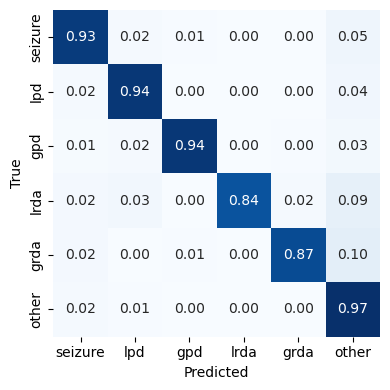

--------------------------------------------------
Fold 4: Training Hard Model


  0%|          | 0/328 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1127]	valid_0's multi_logloss: 1.03691
Evaluated only: multi_logloss
Fold 4: KL Loss Hard: 0.9188


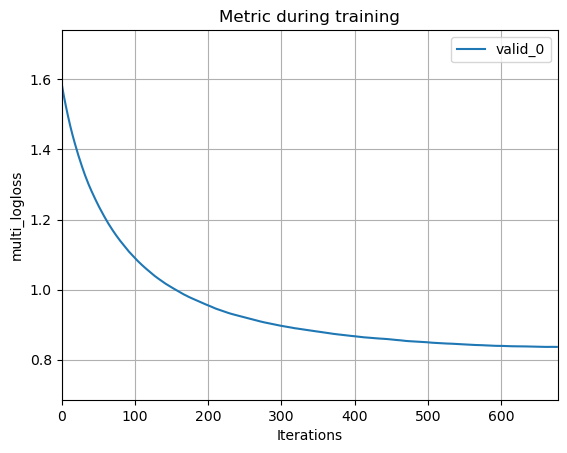

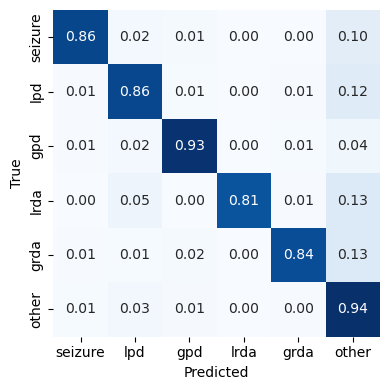

--------------------------------------------------


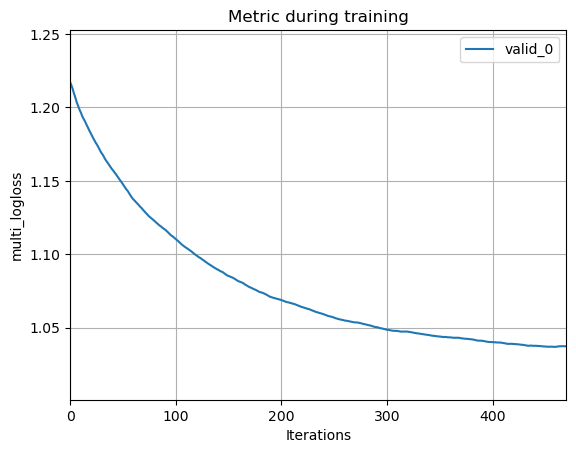

In [6]:
n_folds = 5

train_easy = prepare_folds(train_easy)
train_hard = prepare_folds(train_hard)

oof_df_1 = pd.DataFrame()
oof_df_2 = pd.DataFrame()

for fold in range(n_folds):
    train_folds_easy, valid_folds_easy = get_train_valid_folds(train_easy, fold, 'easy')
    train_folds_hard, valid_folds_hard = get_train_valid_folds(train_hard, fold, 'hard')

    valid_folds = pd.concat([valid_folds_easy, valid_folds_hard], axis=0).reset_index(drop=True)

    valid_folds = valid_folds.merge(train_folds_easy[['eeg_id', 'is_train']], on='eeg_id', how='left')
    valid_folds = valid_folds.merge(train_folds_hard[['eeg_id', 'is_train']], on='eeg_id', how='left')
    not_train = ~(valid_folds['is_train_x'] | valid_folds['is_train_y'])
    valid_folds = valid_folds[ not_train ].reset_index(drop=True)
    valid_folds.drop(['is_train_x', 'is_train_y'], axis=1, inplace=True)

    valid_features = generate_pretrain_features(valid_folds, all_specs, all_eegs, paths.MAE_PRETRAIN_MODEL, DEVICE)
    valid_targets = valid_folds[TARGETS].values.astype(np.float32)

    # Stage 1
    print(f"{'-'*50}\nFold {fold}: Training Easy Model")
    train_features = generate_pretrain_features(train_folds_easy, all_specs, all_eegs, paths.MAE_PRETRAIN_MODEL, DEVICE)
    train_targets = train_folds_easy[TARGETS].values.astype(np.float32)

    lgb_params = {
        'objective': 'multiclass',
        'num_class': 6,
        'metric': 'multi_logloss', #'multi_logloss', #kldiv
        'learning_rate': 0.01,
        'n_estimators': 1000,
        'max_depth': 9,
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    gbm_model_easy, y_pred, kl_loss_easy = train_lgbm(
        train_features, train_targets, valid_features, valid_targets, lgb_params, 'easy')
    print(f"Fold {fold}: KL Loss Easy: {kl_loss_easy:.4f}")
    plot_model_cm(gbm_model_easy, train_features, train_targets)
    lgb.plot_metric(gbm_model_easy)

    joblib.dump(gbm_model_easy, os.path.join(paths.OUTPUT_DIR, f'gbm_classifier_fold_{fold}_easy.pkl'))

    valid_folds[TARGETS_PRED] = y_pred
    oof_df_1 = pd.concat([oof_df_1, valid_folds], axis=0).reset_index(drop=True)

    # Stage 2
    print(f"{'-'*50}\nFold {fold}: Training Hard Model")
    train_features = generate_pretrain_features(train_folds_hard, all_specs, all_eegs,  paths.MAE_PRETRAIN_MODEL, DEVICE)
    train_targets = train_folds_hard[TARGETS].values.astype(np.float32)

    lgb_params.update({'learning_rate': 0.005})

    gbm_model_hard, y_pred, kl_loss_hard = train_lgbm(
        train_features, train_targets, valid_features, valid_targets, lgb_params, 'hard', load_init_model=gbm_model_easy.booster_)

    print(f"Fold {fold}: KL Loss Hard: {kl_loss_hard:.4f}")
    plot_model_cm(gbm_model_hard, train_features, train_targets)
    lgb.plot_metric(gbm_model_hard)
    
    joblib.dump(gbm_model_hard, os.path.join(paths.OUTPUT_DIR, f'gbm_classifier_fold_{fold}_hard.pkl'))

    valid_folds[TARGETS_PRED] = y_pred
    oof_df_2 = pd.concat([oof_df_2, valid_folds], axis=0).reset_index(drop=True)

    print("-"*50)
    

In [ ]:
def get_oof_score(oof_df):
    solution = pd.DataFrame(oof_df[TARGETS].values)
    solution.columns = TARGETS
    solution['id'] = range(len(solution))

    submission = pd.DataFrame(oof_df[TARGETS_PRED].values)
    submission.columns = TARGETS
    submission['id'] = range(len(submission))

    return kl_score(solution, submission, 'id')

In [ ]:
oof_score_1 = get_oof_score(oof_df_1)
oof_score_2 = get_oof_score(oof_df_2)
print(f"OOF Score Easy: {oof_score_1:.4f}")
print(f"OOF Score Hard: {oof_score_2:.4f}")

In [ ]:
# randomly select samples and check the prediction
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex='col', sharey='row')
for i, ax in enumerate(axes.flatten()):
    idx = np.random.randint(0, len(oof_df_2))
    ax.plot(oof_df_2[TARGETS].iloc[idx].values, label='True')
    ax.plot(oof_df_2[TARGETS_PRED].iloc[idx].values, label='Predict')
    ax.set_xticks(range(6))
    ax.set_xticklabels([x.split('_')[0] for x in TARGETS], rotation=0)
    ax.legend()
    ax.grid(True)

fig.tight_layout()
plt.show()

In [ ]:
df_samples = pd.concat([train_easy, train_hard], axis=0).sample(100).reset_index(drop=True)

sample_features = generate_pretrain_features(df_samples, all_specs, all_eegs, paths.MAE_PRETRAIN_MODEL, DEVICE)
sample_targets = df_samples[TARGETS].values.astype(np.float32)

model_files = [f'gbm_classifier_fold_{i}_hard.pkl' for i in range(n_folds)]
models = [joblib.load(os.path.join(paths.OUTPUT_DIR, f)) for f in model_files]

predicts = np.zeros((len(df_samples), 6))

for model in models:
    predicts += model.predict_proba(sample_features) / len(models)
    kl_loss = kl_div(sample_targets, predicts).sum(axis=1).mean()

print(f"Sample KL Loss: {kl_loss:.4f}")

fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex='col', sharey='row')
for i, ax in enumerate(axes.flatten()):
    ax.plot(sample_targets[i], label='True')
    ax.plot(predicts[i], label='Predict')
    ax.set_xticks(range(6))
    ax.set_xticklabels([x.split('_')[0] for x in TARGETS], rotation=0)
    ax.legend()
    ax.grid(True)

fig.tight_layout()
plt.show()